A2 de TAECD

# Questão 1

In [58]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix

from tqdm.notebook import tqdm

# leitura dos dados
dataset = pd.read_csv('Part 1.tsv',sep='\t')
# dataset legivel pelo sklearn
X = dataset.drop('label',axis=1).values
y = dataset['label'].values

# split treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)

In [59]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))

def sigmoid_derivative(output):
    return output * (1.0 - output)

def tanh_derivative(output):
    return 1 - output**2

def cost_function(y, y_hat):
    return -(y*(np.log(y_hat)) + (1 - y)*np.log(1 - y_hat))

def cost_gradient(y, y_hat):
    return -(y / y_hat) + (1.0 - y) /  (1.0 - y_hat)

class MyNeuralNetwork:
    
    def __init__(self, learning_rate : float = 1e-3):
        # inicializar parametros
        self.W1 = np.random.normal(0,1,2+1)
        self.W2 = np.random.normal(0,1,3+1)
        self.lr = learning_rate
        self.steps = []
        self.W1_updates = []
        self.W2_updates = []
        self.costs = []
        
    def forward(self, x : np.array):
        # passo forward
        I1 = np.concatenate([x[:2],[1]])
        A1 = I1.dot(self.W1.T)
        O1 = np.tanh(A1)
        
        I2 = np.concatenate([[O1],x[2:],[1]])
        A2 = I2.dot(self.W2.T)
        O2 = sigmoid(A2)
        
        # salvar valores para backpropagation
        self.steps.append((I1,I2,A1,A2,O1,O2))
        
        return O2
    
    def backpropagation(self, y, yhat):
        
        (I1,I2,A1,A2,O1,O2) = self.steps.pop(0)
        
        # derivada do erro no layer 2
        dE_dO2 = cost_gradient(y,yhat)
        dE_dA2 = dE_dO2 * sigmoid_derivative(O2)
        dE_dW2 = dE_dA2 * I2
        # derivada do erro no layer 1
        dE_dO1 = dE_dO2 * sigmoid_derivative(O1)
        dE_dA1 = dE_dO1 * tanh_derivative(O1)
        dE_dW1 = dE_dA1 * I1
        # update weights
        self.W1 -= dE_dW1 * self.lr
        self.W2 -= dE_dW2 * self.lr
        
        return (dE_dW1,dE_dW2)
        
    def predict(self, X):
        return np.array([self.forward(x) for x in X])
    
    def predict_class(self, X, treshold : float = .5):
        return (self.predict(X) > treshold).astype(int)
    
    def train(self, X, y):
        yhat = self.predict(X)
        weights_update = []
        costs = []
        for (y_,yhat_) in zip(y,yhat):
            weights_update.append(self.backpropagation(y_,yhat_))
            costs.append(cost_function(y_,yhat_))
            
        return weights_update, costs
    
    def fit(self, X, y, epochs:int=20):
        
        for epoch in tqdm(range(epochs),desc='Treinando a rede'):
            updates, costs = self.train(X,y)
            
            uw1 = 0
            uw2 = 0
            avg_cost = np.mean(costs)
            
            for u1,u2 in updates:
                uw1 += u1.mean()
                uw2 += u2.mean()
            
            self.W1_updates.append(uw1)
            self.W2_updates.append(uw2)
            self.costs.append(avg_cost)
            
    def plot_error(self):
        sns.lineplot(data=self.costs)
        plt.show()
            
    def evaluate(self, X, y):
        # previsao de classes
        yhat = self.predict(X)
        yhat_class = self.predict_class(X)
        # acuracia
        acc = accuracy_score(y,yhat_class)
        #auc pr
        precision, recall, tresholds = precision_recall_curve(y,yhat)
        curve  = np.array(sorted(list(zip(recall,precision))))
        auc_pr = auc(curve[:,0],curve[:,1])
        # auc roc
        auc_roc = roc_auc_score(y,yhat)
        # matriz de confusao
        cm = confusion_matrix(y,yhat_class)
        
        print('''
        Accuracy: {}
        AUC-PR  : {}
        AUC-ROC : {}
        
        Confusion Matrix:
        {}
        {}
        '''.format(
            np.round(acc,2),
            np.round(auc_pr,2),
            np.round(auc_roc,2),
            cm[0],cm[1]
        ))

Treinando a rede:   0%|          | 0/30 [00:00<?, ?it/s]


        Accuracy: 0.82
        AUC-PR  : 0.88
        AUC-ROC : 0.89
        
        Confusion Matrix:
        [2802  708]
        [ 560 2930]
        


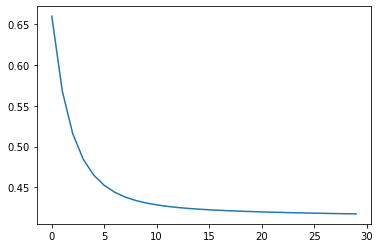

In [60]:
nn = MyNeuralNetwork(learning_rate=1e-4)
nn.fit(X_train,y_train,epochs=30)
nn.evaluate(X_train,y_train)
nn.plot_error()

# Questão 2

In [395]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix

from tqdm.notebook import tqdm

np.random.seed(0)
pd.set_option('max.columns',500)

# leitura dos dados - vamos fazer a leitura de dois arquivos: adult.data e adult.test
# assim teremos o mesmo número de registros do dado como descrito no site fonte
dataset1 = pd.read_csv('adult.data',sep=',',header=None)
dataset2 = pd.read_csv('adult.test',sep=',',skiprows=1,header=None,)

dataset = pd.concat([dataset1,dataset2],axis=0)
dataset.columns = [
    'age','workclass','fnlwgt','education','education-num','marital-status',
    'occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week',
    'native-country','label'
]

# colunas numericas
num_cols = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
# colunas categoricas
cat_cols = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
# variavel objetivo
label = 'label'
# dataset legivel pelo sklearn
X = pd.get_dummies(dataset.drop('label',axis=1),columns=cat_cols,drop_first=True).values
y = (dataset['label'].str.contains('>50K')).astype(int).values

# split treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)

In [396]:
def gini(x):
    classes = np.unique(x)
    N = len(x)
    gini_score = 0
    for cl in classes:
        prob = (x==cl).mean()
        gini_score += prob*(1-prob)
    return gini_score


def recursive_growth(node, min_samples, max_depth, current_depth, X, y, n_features):
    if 'low_region' in node.keys():
        lo = node['low_region']
        hi = node['high_region']
        
        # process left
        classes, counts = np.unique(y[lo], return_counts=True)
        if (len(lo) < min_samples) or (current_depth == max_depth) or (len(classes) == 1):
            if len(lo) > 0:
                node['left'] = {'class':classes[np.argmax(counts)]}
        else:
            node['left'] = DecisionTreeClassifier.get_best_split(X[lo], y[lo], n_features)
            recursive_growth(node['left'], min_samples, max_depth, current_depth + 1, X, y, n_features)

        # process right
        classes, counts = np.unique(y[hi], return_counts=True)
        if (len(hi) < min_samples) or (current_depth == max_depth) or (len(classes) == 1):
            if len(hi) > 0:
                node['right'] = {'class':classes[np.argmax(counts)]}
        else:
            node['right'] = DecisionTreeClassifier.get_best_split(X[hi], y[hi], n_features)
            recursive_growth(node['right'], min_samples, max_depth, current_depth + 1, X, y, n_features)

class DecisionTreeClassifier:
    
    def __init__(self, max_depth=None, min_samples:int=2, n_features=None):
        # inicializa parametros
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
        self.n_features = n_features
        
    @staticmethod
    def create_split(X, feature, treshold):
        return np.where(X[:,feature]<treshold)[0],np.where(X[:,feature]>=treshold)[0]
        
    @staticmethod
    def get_best_split(X,y,n_features=None):
        best_gini = 100
        best_feature = None
        best_treshold = None
        best_l = None
        best_h = None
        # iterar nas features
        n_features = X.shape[1] if n_features is None else n_features
        for feat in np.random.choice(range(X.shape[1]),n_features,replace=False):
            # iterar nos valores unicos
            for treshold in np.unique(X[:, feat]):
                l, h = DecisionTreeClassifier.create_split(X, feat, treshold)
                gini_score = gini(y[l]) + gini(y[h])
                
                if gini_score < best_gini:
                    best_gini = gini_score
                    best_feature = feat
                    best_treshold = treshold
                    best_l = l
                    best_h = h
        return {
            'feature': best_feature,
            'treshold': best_treshold,
            'low_region' : best_l,
            'high_region' : best_h,
        }
    
    def fit(self, X, y):
        self.tree = self.get_best_split(X,y,self.n_features)
        recursive_growth(
            self.tree,
            self.min_samples,
            self.max_depth,
            1, X, y, self.n_features
        )
    
    @staticmethod
    def predict_sample(node, sample):
        if 'class' in node.keys():
            return node['class']
        
        # left node
        elif sample[node['feature']] < node['treshold']:
            # testar se existe o left node (não foi cortado)
            if node.get('left'):
                return DecisionTreeClassifier.predict_sample(node['left'], sample)
            else:
                return DecisionTreeClassifier.predict_sample(node['right'], sample)
        
        # right node
        else:
            # testar se existe o right node (não foi cortado)
            if node.get('right'):
                return DecisionTreeClassifier.predict_sample(node['right'], sample)
            else:
                return DecisionTreeClassifier.predict_sample(node['left'], sample)
        
    def predict(self, X):
        return np.array([DecisionTreeClassifier.predict_sample(self.tree, x) for x in X])

In [397]:
class BaggedTreesClassifier:
    
    def __init__(self, B:int=10, max_depth=None, min_samples:int=1):
        self.B = B
        self.max_depth = max_depth
        self.min_samples = min_samples
        
        self.trees = [DecisionTreeClassifier(max_depth,min_samples) for _ in range(self.B)]
        
    def fit(self, X, y):
        sample_size = int(len(X) / self.B)
        for tree_ind in tqdm(range(self.B),desc='Treinando árvores de decisão'):
            data_sample = np.random.choice(np.array(range(len(X))),sample_size,replace=True)
            self.trees[tree_ind].fit(X[data_sample],y[data_sample])
            
    def predict_proba(self, X):
        predictions = [tree.predict(X) for tree in self.trees]
        return np.array(predictions).mean(axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return (probas>=.5).astype(int)

In [398]:
bag_model = BaggedTreesClassifier(B=10,max_depth=6,min_samples=100)
bag_model.fit(X_train,y_train)

Treinando árvores de decisão:   0%|          | 0/10 [00:00<?, ?it/s]

In [394]:
np.unique(bag_model.predict(X_test),return_counts=1)

(array([0, 1]), array([14055,   598], dtype=int64))

# Questão 3

In [404]:
class RandomForestClassifier:
    
    def __init__(self, m:int=None, n_trees:int=10, max_depth=None, min_samples:int=1):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples = min_samples
        
        self.trees = [DecisionTreeClassifier(max_depth,min_samples,m) for _ in range(self.n_trees)]
        
    def fit(self, X, y):
        sample_size = int(len(X) / self.n_trees)
        for tree_ind in tqdm(range(self.n_trees),desc='Treinando árvores de decisão'):
            data_sample = np.random.choice(np.array(range(len(X))),sample_size,replace=True)
            self.trees[tree_ind].fit(X[data_sample],y[data_sample])
            
    def predict_proba(self, X):
        predictions = [tree.predict(X) for tree in self.trees]
        return np.array(predictions).mean(axis=0)
    
    def predict(self, X):
        probas = self.predict_proba(X)
        return (probas>=.5).astype(int)

In [426]:
rf_model = RandomForestClassifier(m=10,n_trees=100,max_depth=10,min_samples=2)
rf_model.fit(X_train,y_train)

Treinando árvores de decisão:   0%|          | 0/100 [00:00<?, ?it/s]

In [428]:
np.unique(rf_model.predict(X_train),return_counts=1)

(array([0, 1]), array([33858,   331], dtype=int64))

In [429]:
np.unique(y_train,return_counts=1)

(array([0, 1]), array([25955,  8234], dtype=int64))